In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# to process and visualize type data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import shutil
import random
import cv2

import string

# fixed figure size
plt.rcParams["figure.figsize"] = (21, 12)

# to open zip file
from zipfile import ZipFile

In [3]:
# image preprocessing
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img

# multilabel preprocessing
from sklearn.preprocessing import MultiLabelBinarizer

# train-test data
from sklearn.model_selection import train_test_split

# to build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.activations import sigmoid, softmax

# cost function / optimizer
from tensorflow.keras.optimizers import Adam

In [4]:
# font configuration, because i am control freak
SMALL_SIZE = 12
MED_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=SMALL_SIZE)
plt.rc("axes", titlesize=SMALL_SIZE)
plt.rc("axes", labelsize=MED_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

# Process and Prepare Data

In [5]:
ZIP_PATH = "/content/drive/MyDrive/Datasets/poke.zip"
CSV_PATH = "/content/Pokemon.csv"

In [6]:
def OpenZip(path, destination=None):
  with ZipFile(path, "r") as f:
    print("Extracting files...")
    f.extractall(destination)
    print("Done!")

In [7]:
OpenZip(ZIP_PATH, destination="/content/")

Extracting files...
Done!


In [8]:
ROOT_PATH = "/content/pokemon"

In [9]:
generations = os.listdir(ROOT_PATH)
generations

['icons', 'sugimori', 'overworld', 'conquest', 'main-sprites']

In [10]:
BASE_DIR = "/content/Pokemons"
TRAIN_DIR = os.path.join(BASE_DIR, "training")
VAL_DIR = os.path.join(BASE_DIR, "validation")

# if cell is run multiple times, rmpty it
if os.path.exists(BASE_DIR):
  shutil.rmtree(BASE_DIR)

os.makedirs(BASE_DIR)
os.makedirs(TRAIN_DIR)
os.makedirs(VAL_DIR)

In [11]:
df = pd.read_csv(CSV_PATH)
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [ ]:
df.shape

(800, 13)

In [12]:
pokemon_types = df["Type 1"].unique()
pokemon_types

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [13]:
for t in pokemon_types:
  os.makedirs(os.path.join(TRAIN_DIR, t))
  os.makedirs(os.path.join(VAL_DIR, t))
print("Type directories are created!")

Type directories are created!


In [14]:
count_pokemons = {"conquest": 0,
                  "icons": 0,
                  "main-sprites": 0,
                  "overworld": 0,
                  "sugimori": 0}

for subfolder in os.listdir(ROOT_PATH):
  sub = os.path.join(ROOT_PATH, subfolder)
  for im in os.listdir(sub):
    count_pokemons[subfolder] += 1
    #print(im)

count_pokemons
# main-sprites and overworld folder has subdirectories.
# handle them separately

{'conquest': 202,
 'icons': 945,
 'main-sprites': 13,
 'overworld': 6,
 'sugimori': 852}

In [15]:
type_lists = {}
for t in pokemon_types:
  type_lists[t] = []

type_lists

{'Grass': [],
 'Fire': [],
 'Water': [],
 'Bug': [],
 'Normal': [],
 'Poison': [],
 'Electric': [],
 'Ground': [],
 'Fairy': [],
 'Fighting': [],
 'Psychic': [],
 'Rock': [],
 'Ghost': [],
 'Ice': [],
 'Dragon': [],
 'Dark': [],
 'Steel': [],
 'Flying': []}

In [16]:
for subfolder in os.listdir("/content/pokemon/main-sprites"):
      foldername = os.path.join("/content/pokemon/main-sprites", subfolder)
      print(foldername)

/content/pokemon/main-sprites/red-green
/content/pokemon/main-sprites/gold
/content/pokemon/main-sprites/crystal
/content/pokemon/main-sprites/red-blue
/content/pokemon/main-sprites/silver
/content/pokemon/main-sprites/yellow
/content/pokemon/main-sprites/emerald
/content/pokemon/main-sprites/black-white
/content/pokemon/main-sprites/firered-leafgreen
/content/pokemon/main-sprites/ruby-sapphire
/content/pokemon/main-sprites/heartgold-soulsilver
/content/pokemon/main-sprites/platinum
/content/pokemon/main-sprites/diamond-pearl


In [ ]:
# DO NOT RUN
# second dataset

BASE_DIR = "/content/Pokemons2"
TRAIN_DIR = os.path.join(BASE_DIR, "training")
VAL_DIR = os.path.join(BASE_DIR, "validation")

# if cell is run multiple times, rmpty it
if os.path.exists(BASE_DIR):
  shutil.rmtree(BASE_DIR)

os.makedirs(BASE_DIR)
os.makedirs(TRAIN_DIR)
os.makedirs(VAL_DIR)

for t in pokemon_types:
  os.makedirs(os.path.join(TRAIN_DIR, t))
  os.makedirs(os.path.join(VAL_DIR, t))
print("Type directories are created!")

Type directories are created!


In [17]:
def create_type_path_lists(base_dir):
  """ creates lists for each pokemon type that contains corresponding type of pokemon path"""
  
  alphabet = list(string.ascii_lowercase)

  type_lists_dict = {}
  for t in pokemon_types:
    type_lists_dict[t] = []

  if base_dir.split("/")[-1] in ["main-sprites", "overworld"]:
    for subfolder in os.listdir(base_dir):
      foldername = os.path.join(base_dir, subfolder)
      for filename in os.listdir(foldername):
        # eliminate pokemons that contains hyphen names like: 423-west.png
        if filename.split(".")[0].endswith(tuple(alphabet)):     
          #print("Excluded: ", im)
          continue
        if not os.path.isdir(os.path.join(foldername, filename)):
          # check if it is a folder or not
          poke_id = int(filename.split(".")[0])
          type1 = df.iloc[poke_id-1]["Type 1"]
          type_lists_dict[type1].append(os.path.join(foldername, filename))
    return type_lists_dict

  for fname in os.listdir(base_dir):
    filename = os.path.join(base_dir, fname)
    # eliminate pokemons that contains hyphen names like: 423-west.png
    if filename.split(".")[0].endswith(tuple(alphabet)):     
      #print("Excluded: ", im)
      continue
    if not os.path.isdir(filename):
      # check if it is a folder or not
      poke_id = int(fname.split(".")[0])
      type1 = list(df[df["#"] == poke_id]["Type 1"])[0]
      type_lists_dict[type1].append(filename)
  return type_lists_dict

#conquest_type_path_dict = create_type_path_lists("/content/pokemon/conquest")
#sugimori_type_path_dict = create_type_path_lists("/content/pokemon/sugimori")
#icons_type_path_dict = create_type_path_lists("/content/pokemon/icons")
#main_sprites_type_path_dict = create_type_path_lists("/content/pokemon/main-sprites")
#overworld_type_path_dict = create_type_path_lists("/content/pokemon/overworld")

# works very well <3

In [18]:
conquest_type_path_dict = create_type_path_lists("/content/pokemon/conquest")
sugimori_type_path_dict = create_type_path_lists("/content/pokemon/sugimori")
icons_type_path_dict = create_type_path_lists("/content/pokemon/icons")
main_sprites_type_path_dict = create_type_path_lists("/content/pokemon/main-sprites")
overworld_type_path_dict = create_type_path_lists("/content/pokemon/overworld")

for k in conquest_type_path_dict.keys():
  print(f"{k} has {len(conquest_type_path_dict[k])} paths.")

print("\n-----------------------------------\n")

for k in sugimori_type_path_dict.keys():
  print(f"{k} has {len(sugimori_type_path_dict[k])} paths.")

print("\n-----------------------------------\n")

for k in icons_type_path_dict.keys():
  print(f"{k} has {len(icons_type_path_dict[k])} paths.")

print("\n-----------------------------------\n")

for k in main_sprites_type_path_dict.keys():
  print(f"{k} has {len(main_sprites_type_path_dict[k])} paths.")

print("\n-----------------------------------\n")

for k in overworld_type_path_dict.keys():
  print(f"{k} has {len(overworld_type_path_dict[k])} paths.")

Grass has 14 paths.
Fire has 14 paths.
Water has 14 paths.
Bug has 15 paths.
Normal has 19 paths.
Poison has 9 paths.
Electric has 13 paths.
Ground has 9 paths.
Fairy has 0 paths.
Fighting has 8 paths.
Psychic has 16 paths.
Rock has 12 paths.
Ghost has 14 paths.
Ice has 10 paths.
Dragon has 12 paths.
Dark has 12 paths.
Steel has 9 paths.
Flying has 0 paths.

-----------------------------------

Grass has 66 paths.
Fire has 47 paths.
Water has 105 paths.
Bug has 63 paths.
Normal has 93 paths.
Poison has 28 paths.
Electric has 36 paths.
Ground has 30 paths.
Fairy has 17 paths.
Fighting has 25 paths.
Psychic has 47 paths.
Rock has 41 paths.
Ghost has 23 paths.
Ice has 23 paths.
Dragon has 24 paths.
Dark has 28 paths.
Steel has 22 paths.
Flying has 3 paths.

-----------------------------------

Grass has 66 paths.
Fire has 47 paths.
Water has 105 paths.
Bug has 63 paths.
Normal has 93 paths.
Poison has 28 paths.
Electric has 36 paths.
Ground has 30 paths.
Fairy has 17 paths.
Fighting has 2

In [19]:
# empty directories if you run multiple times

#training paths
TR_PATHS = ["/content/Pokemons/training/Bug",
            "/content/Pokemons/training/Dark",
            "/content/Pokemons/training/Dragon",
            "/content/Pokemons/training/Electric",
            "/content/Pokemons/training/Fairy",
            "/content/Pokemons/training/Fighting",
            "/content/Pokemons/training/Fire",
            "/content/Pokemons/training/Flying",
            "/content/Pokemons/training/Ghost",
            "/content/Pokemons/training/Grass",
            "/content/Pokemons/training/Ice",
            "/content/Pokemons/training/Normal",
            "/content/Pokemons/training/Poison",
            "/content/Pokemons/training/Psychic",
            "/content/Pokemons/training/Rock",
            "/content/Pokemons/training/Steel",
            "/content/Pokemons/training/Water",
            ]

# val paths
VL_PATHS = ["/content/Pokemons/validation/Bug",
            "/content/Pokemons/validation/Dark",
            "/content/Pokemons/validation/Dragon",
            "/content/Pokemons/validation/Electric",
            "/content/Pokemons/validation/Fairy",
            "/content/Pokemons/validation/Fighting",
            "/content/Pokemons/validation/Fire",
            "/content/Pokemons/validation/Flying",
            "/content/Pokemons/validation/Ghost",
            "/content/Pokemons/validation/Grass",
            "/content/Pokemons/validation/Ice",
            "/content/Pokemons/validation/Normal",
            "/content/Pokemons/validation/Poison",
            "/content/Pokemons/validation/Psychic",
            "/content/Pokemons/validation/Rock",
            "/content/Pokemons/validation/Steel",
            "/content/Pokemons/validation/Water",
            ]

for i in range(17):
  if len(os.listdir(TR_PATHS[i])) > 0:
    for file in os.scandir(TR_PATHS[i]):
      if file.path.split("/")[-1] != '.ipynb_checkpoints':
        os.remove(file.path)

  if len(os.listdir(VL_PATHS[i])) > 0:
    for file in os.scandir(VL_PATHS[i]):
      if file.path.split("/")[-1] != '.ipynb_checkpoints':
        os.remove(file.path)

In [20]:
def split_data(base_dir, type_path_dict, split_size):
  """
  Gets type_path_dict, if image len is not zero, appends it to training or validation folders by shuffling types
  """

  to_train_dir = os.path.join(base_dir, "training")
  to_val_dir = os.path.join(base_dir, "validation")
  
  for type_key in type_path_dict.keys():
    tmp_type_files = []
    type_files = type_path_dict[type_key]

    for f in type_files:
      if os.path.getsize(f):
        tmp_type_files.append(f)
      elif f == "/content/pokemon/main-sprites/black-white/0.png":
        print("Fucking egg found! : ", f)
        continue
      else:
        print("{} is zero length, so ignoring.".format(f))
    n_type = len(tmp_type_files)
    split_point = int(split_size * n_type)
    shuffled = random.sample(tmp_type_files, n_type)

    train_type = shuffled[:split_point]
    test_type = shuffled[split_point:]
    
    for type_path in train_type:
      to_copy = os.path.join(to_train_dir, type_key)
      copy_name = "".join(type_path.split("/")[3:])
      shutil.copyfile(type_path, os.path.join(to_copy, copy_name))
    
    for type_path in test_type:
      to_copy = os.path.join(to_val_dir, type_key)
      copy_name = "".join(type_path.split("/")[3:])
      shutil.copyfile(type_path, os.path.join(to_copy, copy_name))

In [22]:
split_size = 0.7

In [27]:
# split_size = 0.9

split_data(BASE_DIR, conquest_type_path_dict, split_size)
split_data(BASE_DIR, sugimori_type_path_dict, split_size)
split_data(BASE_DIR, icons_type_path_dict, split_size)
split_data(BASE_DIR, main_sprites_type_path_dict, split_size)
split_data(BASE_DIR, overworld_type_path_dict, split_size)

In [28]:
# save my preciousss
shutil.make_archive("ProcessedPokemonData" + str(split_size)[2:], 'zip', "/content/Pokemons")

'/content/ProcessedPokemonData7.zip'

In [29]:
# Training and validation splits
for i in range(17):
  print(f"There are {len(os.listdir(TR_PATHS[i]))} images of {(TR_PATHS[i].split('/')[-1].lower())}'s for training")
  print(f"There are {len(os.listdir(VL_PATHS[i]))} images of {(VL_PATHS[i].split('/')[-1].lower())}'s for validation.")
  print()

There are 666 images of bug's for training
There are 376 images of bug's for validation.

There are 193 images of dark's for training
There are 111 images of dark's for validation.

There are 194 images of dragon's for training
There are 113 images of dragon's for validation.

There are 375 images of electric's for training
There are 213 images of electric's for validation.

There are 120 images of fairy's for training
There are 72 images of fairy's for validation.

There are 230 images of fighting's for training
There are 133 images of fighting's for validation.

There are 500 images of fire's for training
There are 286 images of fire's for validation.

There are 6 images of flying's for training
There are 4 images of flying's for validation.

There are 199 images of ghost's for training
There are 113 images of ghost's for validation.

There are 628 images of grass's for training
There are 358 images of grass's for validation.

There are 175 images of ice's for training
There are 98 i

In [ ]:
# DO NOT RUN

def split_data2(base_dir, type_path_dict, to_training=True):
  """
  Gets type_path_dict, if image len is not zero, appends it to training or validation folders by shuffling types
  """

  to_train_dir = os.path.join(base_dir, "training")
  to_val_dir = os.path.join(base_dir, "validation")
  
  for type_key in type_path_dict.keys():
    tmp_type_files = []
    type_files = type_path_dict[type_key]

    for f in type_files:
      if os.path.getsize(f):
        tmp_type_files.append(f)
      elif f == "/content/pokemon/main-sprites/black-white/0.png":
        print("Fucking egg found! : ", f)
        continue
      else:
        print("{} is zero length, so ignoring.".format(f))
    n_type = len(tmp_type_files)
    shuffled = random.sample(tmp_type_files, n_type)
    
    if to_training:
      for type_path in shuffled:
        to_copy = os.path.join(to_train_dir, type_key)
        copy_name = "".join(type_path.split("/")[3:])
        shutil.copyfile(type_path, os.path.join(to_copy, copy_name))
    else:
      for type_path in shuffled:
        to_copy = os.path.join(to_val_dir, type_key)
        copy_name = "".join(type_path.split("/")[3:])
        shutil.copyfile(type_path, os.path.join(to_copy, copy_name))

In [ ]:
# DO NOT RUN

split_data2(BASE_DIR, conquest_type_path_dict)
split_data2(BASE_DIR, icons_type_path_dict)
split_data2(BASE_DIR, main_sprites_type_path_dict)
split_data2(BASE_DIR, overworld_type_path_dict)
split_data2(BASE_DIR, sugimori_type_path_dict, False)

In [30]:
def train_val_generators_1(train_dir, val_dir):
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  train_gen = ImageDataGenerator(rescale=1/255.)
  val_gen = ImageDataGenerator(rescale=1/255.)

  train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                  batch_size=32,
                                                  class_mode="categorical",
                                                  target_size=(32, 32))
  val_generator = val_gen.flow_from_directory(directory=val_dir,
                                              batch_size=32,
                                              class_mode="categorical",
                                              target_size=(32, 32))
  return train_generator, val_generator

In [31]:
train_dir = "/content/Pokemons/training"
val_dir = "/content/Pokemons/validation"

In [32]:
# DO NOT RUN

train_dir2 = "/content/Pokemons2/training"
val_dir2 = "/content/Pokemons2/validation"

In [33]:
train_generator, val_generator = train_val_generators_1(train_dir, val_dir)

Found 7148 images belonging to 18 classes.
Found 4072 images belonging to 18 classes.


# Model 1 -> overfitted

In [34]:
# define callbacks

import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, model, logs={}):
    if logs.get("accuracy") > 0.9:
      print("\nAccuracy is greater than 90%, so stopping.")
      self.model.stop_training = True

callback_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
def create_model():
  model = Sequential([Conv2D(32, (3,3), input_shape=(32, 32, 3), activation="relu"),
                               MaxPooling2D(2,2),
                               Conv2D(32, (3,3), activation="relu"),
                               MaxPooling2D(2,2),
                               Dropout(0.2),
                               
                               Flatten(),
                               Dense(128, activation="relu"),
                               Dense(18, activation="softmax")
                               ])
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
model = create_model()

In [ ]:
callback = myCallback()

In [ ]:
tf.keras.backend.clear_session()

hist1 = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=[callback])

Epoch 1/100
 15/221 [=>............................] - ETA: 28s - loss: 2.7467 - accuracy: 0.1396

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


221/221 [==============================] - 25s 115ms/step - loss: 2.6521 - accuracy: 0.1603 - val_loss: 2.6582 - val_accuracy: 0.1622
Epoch 2/100
221/221 [==============================] - 23s 105ms/step - loss: 2.6105 - accuracy: 0.1771 - val_loss: 2.6265 - val_accuracy: 0.1828
Epoch 3/100
221/221 [==============================] - 23s 103ms/step - loss: 2.5659 - accuracy: 0.1833 - val_loss: 2.5999 - val_accuracy: 0.1804
Epoch 4/100
221/221 [==============================] - 25s 115ms/step - loss: 2.5049 - accuracy: 0.2009 - val_loss: 2.5385 - val_accuracy: 0.1877
Epoch 5/100
221/221 [==============================] - 23s 104ms/step - loss: 2.4112 - accuracy: 0.2313 - val_loss: 2.5376 - val_accuracy: 0.1913
Epoch 6/100
221/221 [==============================] - 23s 103ms/step - loss: 2.2779 - accuracy: 0.2629 - val_loss: 2.5056 - val_accuracy: 0.1949
Epoch 7/100
221/221 [==============================] - 23s 104ms/step - loss: 2.1232 - accuracy: 0.3148 - val_loss: 2.4216 - val_accurac

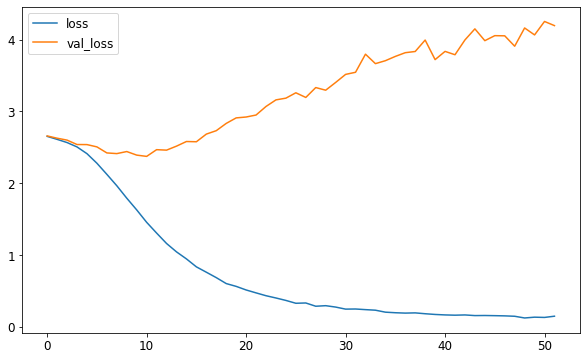

In [ ]:
eps = range(len(hist1.history["loss"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist1.history["loss"])
plt.plot(eps, hist1.history["val_loss"])
plt.legend(["loss", "val_loss"])

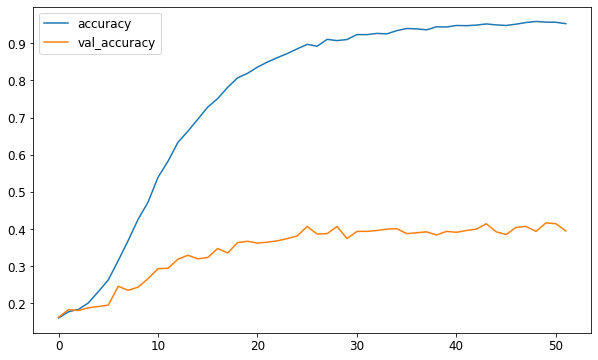

In [ ]:
eps = range(len(hist1.history["accuracy"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist1.history["accuracy"])
plt.plot(eps, hist1.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

# Model 2

- added batch norm
- more dropouts

In [35]:
def create_model():
  model = Sequential([Conv2D(32, (3,3), input_shape=(32, 32, 3), activation="relu"),
                               BatchNormalization(),
                               MaxPooling2D(2,2),
                               Dropout(0.2),
                      
                               Conv2D(32, (3,3), activation="relu"),
                               BatchNormalization(),
                               MaxPooling2D(2,2),
                               Dropout(0.2),
                               
                               Flatten(),
                               Dense(128, activation="relu"),
                               Dense(18, activation="softmax")
                               ])
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
def train_val_generators_2(train_dir, val_dir):
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  train_gen = ImageDataGenerator(rescale=1/255.,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode="nearest")
  val_gen = ImageDataGenerator(rescale=1/255.)

  train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                  batch_size=32,
                                                  class_mode="categorical",
                                                  target_size=(64, 64))
  val_generator = val_gen.flow_from_directory(directory=val_dir,
                                              batch_size=32,
                                              class_mode="categorical",
                                              target_size=(64, 64))
  return train_generator, val_generator

In [36]:
train_generator, val_generator = train_val_generators_1(train_dir, val_dir)
model2 = create_model()
callback_acc = myCallback()

hist2 = model2.fit(train_generator, validation_data=val_generator, epochs=1000, callbacks=[callback_acc, callback_earlystopping])

Found 7148 images belonging to 18 classes.
Found 4072 images belonging to 18 classes.
Epoch 1/1000
  7/224 [..............................] - ETA: 18s - loss: 3.9200 - accuracy: 0.0714

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


224/224 [==============================] - 42s 142ms/step - loss: 2.7968 - accuracy: 0.1465 - val_loss: 4.0399 - val_accuracy: 0.0516
Epoch 2/1000
224/224 [==============================] - 32s 145ms/step - loss: 2.6142 - accuracy: 0.1746 - val_loss: 2.6767 - val_accuracy: 0.1515
Epoch 3/1000
224/224 [==============================] - 31s 139ms/step - loss: 2.5658 - accuracy: 0.1805 - val_loss: 2.4904 - val_accuracy: 0.2070
Epoch 4/1000
224/224 [==============================] - 31s 140ms/step - loss: 2.4985 - accuracy: 0.1956 - val_loss: 2.4255 - val_accuracy: 0.2267
Epoch 5/1000
224/224 [==============================] - 31s 140ms/step - loss: 2.4266 - accuracy: 0.2269 - val_loss: 2.3330 - val_accuracy: 0.2579
Epoch 6/1000
224/224 [==============================] - 31s 140ms/step - loss: 2.3161 - accuracy: 0.2454 - val_loss: 2.1665 - val_accuracy: 0.3121
Epoch 7/1000
224/224 [==============================] - 31s 140ms/step - loss: 2.1844 - accuracy: 0.2925 - val_loss: 2.0310 - val_a

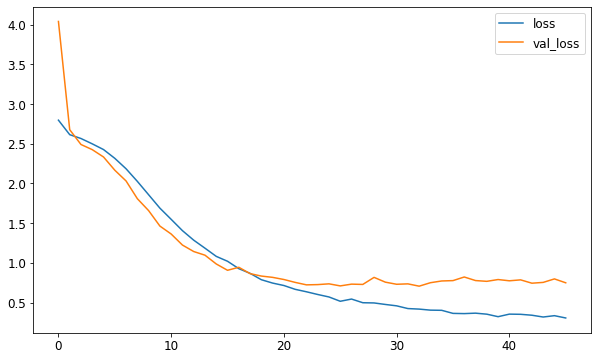

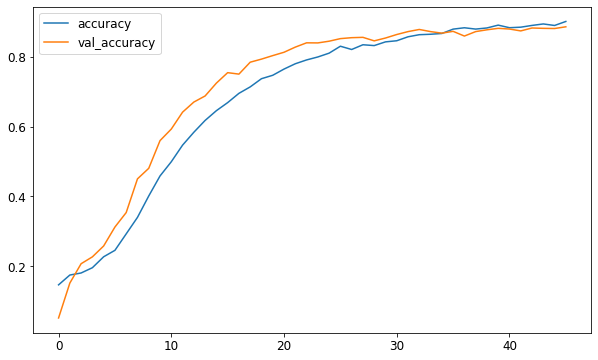

In [37]:
eps = range(len(hist2.history["loss"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist2.history["loss"])
plt.plot(eps, hist2.history["val_loss"])
plt.legend(["loss", "val_loss"])

eps = range(len(hist2.history["accuracy"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist2.history["accuracy"])
plt.plot(eps, hist2.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

In [38]:
# FOUND THE DESIRED RESULTS!

In [ ]:
model2.save("model2.h5")

from google.colab import files
files.download("model2.h5")

# Model 3
### approach 1 - failed
- increased dropout rates from 0.2 to 0.4
- dense layer from 128 to 64

### approach 2 - failed
- more layers
- change optimizer from adam to sgd

### approach 3 - failed
- activation -> selu
- dropout 0.4

### approach 4 - failed, extreme overfitting!
- change dataset : all conquest, icons, main sprites and overworld poke zip images to train and sugimori to test
- update callback to early stopping

### approach 5 - failed, worst
- augment data on changed dataset

### approach 6 - failed
- old dataset
- additional one block conv2d

### approach 7 -
- newer dataset just use sugimori art

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
def create_model():
  model = Sequential([Conv2D(32, (3,3), input_shape=(32, 32, 3), activation="relu"),
                               BatchNormalization(),
                               MaxPooling2D(2,2),
                               Dropout(0.2),
                      
                               Conv2D(32, (3,3), activation="relu"),
                               BatchNormalization(),
                               MaxPooling2D(2,2),
                               Dropout(0.2),
                      
                      Conv2D(32, (3,3), activation="relu"),
                               BatchNormalization(),
                               MaxPooling2D(2,2),
                               Dropout(0.2),
                               
                               Flatten(),
                               Dense(128, activation="relu"),
                               Dense(18, activation="softmax")
                               ])
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
tf.keras.backend.clear_session()

train_generator, val_generator = train_val_generators_1(train_dir, val_dir)
model3 = create_model()

hist3 = model3.fit(train_generator, validation_data=val_generator, epochs=1000, callbacks=[callback])

Found 7048 images belonging to 18 classes.
Found 826 images belonging to 18 classes.
Epoch 1/1000
 11/221 [>.............................] - ETA: 22s - loss: 3.6703 - accuracy: 0.1023

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


221/221 [==============================] - 24s 106ms/step - loss: 2.8372 - accuracy: 0.1376 - val_loss: 3.0188 - val_accuracy: 0.0569
Epoch 2/1000
221/221 [==============================] - 22s 102ms/step - loss: 2.6623 - accuracy: 0.1573 - val_loss: 2.7862 - val_accuracy: 0.1065
Epoch 3/1000
221/221 [==============================] - 23s 103ms/step - loss: 2.6056 - accuracy: 0.1710 - val_loss: 2.6628 - val_accuracy: 0.1695
Epoch 4/1000
221/221 [==============================] - 23s 102ms/step - loss: 2.5799 - accuracy: 0.1791 - val_loss: 2.6835 - val_accuracy: 0.1380
Epoch 5/1000
221/221 [==============================] - 22s 102ms/step - loss: 2.5442 - accuracy: 0.1853 - val_loss: 2.5778 - val_accuracy: 0.1743
Epoch 6/1000
221/221 [==============================] - 22s 102ms/step - loss: 2.5143 - accuracy: 0.1921 - val_loss: 2.5825 - val_accuracy: 0.1755
Epoch 7/1000
221/221 [==============================] - 23s 103ms/step - loss: 2.4961 - accuracy: 0.1959 - val_loss: 2.5766 - val_a

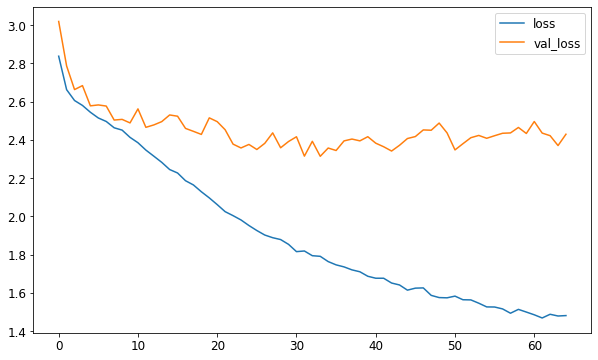

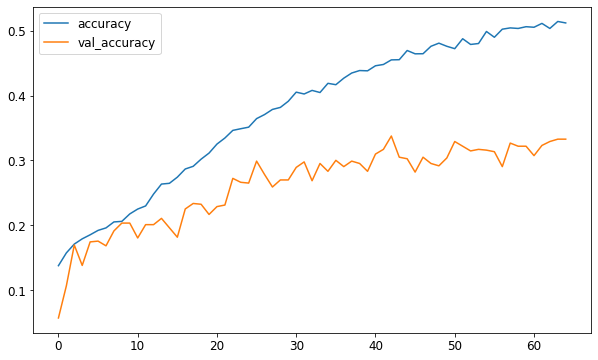

In [ ]:
eps = range(len(hist3.history["loss"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist3.history["loss"])
plt.plot(eps, hist3.history["val_loss"])
plt.legend(["loss", "val_loss"])

eps = range(len(hist3.history["accuracy"]))
plt.figure(figsize=(10, 6))
plt.plot(eps, hist3.history["accuracy"])
plt.plot(eps, hist3.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])

In [ ]:
model2.save("model2.h5")

from google.colab import files
files.download("model2.h5")